### 보스턴 주택가격 예측
* OLS 기반의 회귀 계수 계산은 입력 피처의 독립성에 많은 영향을 받음
* 피처 간의 상관관계가 매우 높은 경우분산이 매우 커져서 오류에 민감해짐 -> 다중 공선성 문제
* 상관관계가 높은 피처가 많은 경우 독립적인 중요한 피처만 남기고 제거하거나 규제를 적용
    * PCA도 고려

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
%matplotlib inline

# boston 데이터 세트 로드
boston=load_boston()

bostonDF=pd.DataFrame(boston.data, columns=boston.feature_names)

bostonDF['PRICE']=boston.target
print(bostonDF.shape)
bostonDF.head()

(506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [3]:
bostonDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
PRICE      506 non-null float64
dtypes: float64(14)
memory usage: 55.5 KB


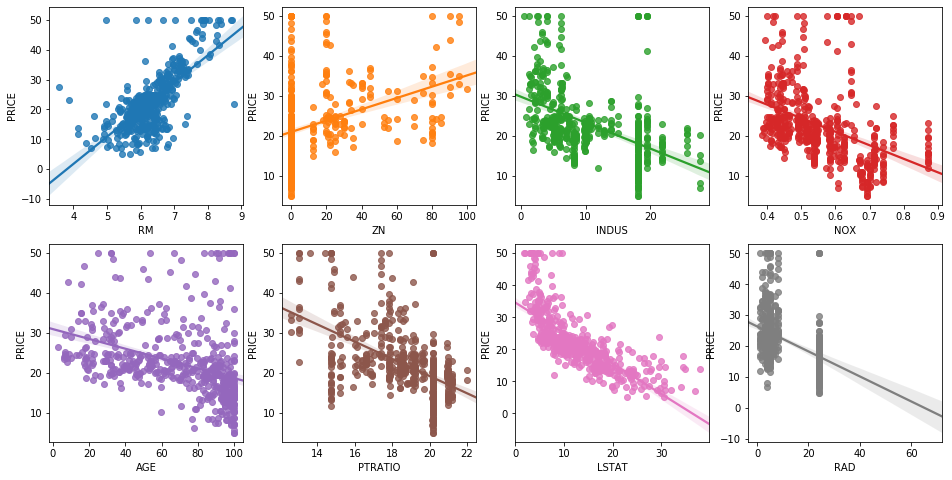

In [5]:
# 각 칼럼이 회귀 결과에 미치는 영향이 어느 정도인지 시각화해서 알아보기
fig, axs=plt.subplots(figsize=(16, 8), ncols=4, nrows=2)
lm_features=['RM', 'ZN', 'INDUS', 'NOX', 'AGE', 'PTRATIO', 'LSTAT', 'RAD']

for i, feature in enumerate(lm_features):
    row=int(i/4)
    col=i%4
    
    #seaborn의 regplot을 이용해 산점도와 선형회귀 직선을 함께 표현
    sns.regplot(x=feature, y='PRICE', data=bostonDF, ax=axs[row][col])

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target=bostonDF['PRICE']
X_data=bostonDF.drop(['PRICE'], axis=1, inplace=False)

X_train, X_test, y_train, y_test=train_test_split(X_data, y_target, test_size=0.3, random_state=156)

# 선형 회귀 OLS로 학습/예측/평가 수행
lr=LinearRegression()
lr.fit(X_train, y_train)
y_preds=lr.predict(X_test)
mse=mean_squared_error(y_test, y_preds)
rmse=np.sqrt(mse)

print('MSE: {0:.3f}, RMSE: {1:.3f}'.format(mse, rmse))
print('Variance score: {0:.3f}'.format(r2_score(y_test, y_preds)))

MSE: 17.297, RMSE: 4.159
Variance score: 0.757


In [7]:
print('절편 값: ', lr.intercept_)
print('회귀 계수값: ', np.round(lr.coef_, 1))

절편 값:  40.995595172164336
회귀 계수값:  [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [8]:
# coef_ 속성은 회귀 계수 값만 가지고 있으므로 이를 피처별 회귀 계수 값으로 다시 매핑하고, 높은 값 순으로 출력

# 회귀 계수를 큰 값 순으로 정렬하기 위해 Serires로 생성
coeff=pd.Series(data=np.round(lr.coef_, 1), index=X_data.columns)
coeff.sort_values(ascending=False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
B           0.0
TAX        -0.0
AGE         0.0
INDUS       0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

In [10]:
# 5개의 폴드 세트에서 교차 검증으로 MSE와 RMSE 측정

from sklearn.model_selection import cross_val_score

y_target=bostonDF['PRICE']
X_data=bostonDF.drop(['PRICE'], axis=1, inplace=False)
lr=LinearRegression()

# cross_val_score() 로 5폴드 세트로 MSE를 구한뒤 다시 RMSE구함
neg_mse_scores=cross_val_score(lr, X_data, y_target, scoring="neg_mean_squared_error", cv=5)
rmse_scores=np.sqrt(-1*neg_mse_scores)
avg_rmse=np.mean(rmse_scores)

# cross_val_score(scoring="neg_mean_squared_error")로 반환된 값은 모두 음수
print(' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print(' 5 folds 의 개별 RMSE scores: ', np.round(rmse_scores, 2))
print(' 5 folds 의 평균 RMSE : {0:.3f}'.format(avg_rmse))

# MSE값이 낮을수록 좋은 회귀모델

 5 folds 의 개별 Negative MSE scores:  [-12.46 -26.05 -33.07 -80.76 -33.31]
 5 folds 의 개별 RMSE scores:  [3.53 5.1  5.75 8.99 5.77]
 5 folds 의 평균 RMSE : 5.829
